In [35]:
from skimage.io import imread
from skimage import morphology
import pyclesperanto_prototype as cle
from pyclesperanto_prototype import Image, plugin_function
import numpy as np

In [36]:
cle.select_device()

<Intel(R) Iris(TM) Plus Graphics on Platform: Apple (36 refs)>

# Initialisation

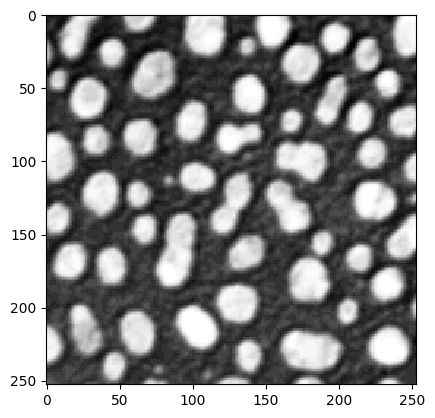

In [37]:
image = imread("https://imagej.nih.gov/nih-image/download/images/Blobs/Blobs")
image = image[:253, :253]
image = cle.push(image)
cle.imshow(image)

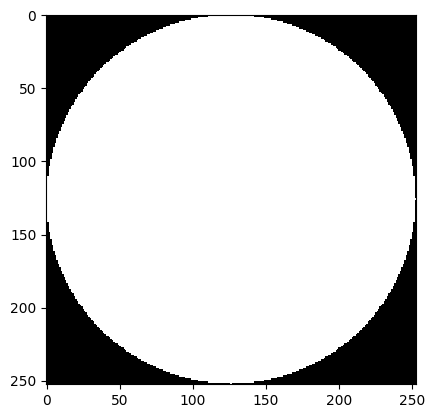

In [38]:
disk = morphology.disk(int(image.shape[0] // 2))
disk = cle.push(disk)
cle.imshow(disk)

# Main Loop

In [49]:
@plugin_function
def morphological_snake(input_image: Image, contour_image: Image=None, output_image: Image=None, n_iter: int=100, smoothing: int=1, lambda1: float=1, lambda2: float=1) -> Image:
    
    if contour_image is None:
        contour_image = morphology.disk(int(input_image.shape[0] // 2))
    
    cle.greater_constant(contour_image, constant=0, destination=output_image)
    
    for _ in range(n_iter):
        invert_curve = 1 - output_image
        outside_image = (input_image * invert_curve).sum()
        outside_curve_area = invert_curve.sum() + 1e-8
        c0 = outside_image / outside_curve_area

        inside_image = (input_image * output_image).sum()
        inside_curve_area = output_image.sum() + 1e-8
        c1 = inside_image / inside_curve_area

        # absolute_gradient = cle.create_like(curve)
        # permutation = np.arange(0, image.ndim)
        # for e in range(len(permutation)):
        #     transposed_image = curve.transpose(np.roll(permutation, e))
        #     absolute_gradient = absolute_gradient + cle.absolute(cle.gradient_x(transposed_image)).transpose(np.roll(permutation, e))

        absolute_gradient = cle.create_like(output_image)

        for e in range(input_image.ndim):
            if e == 0:   
                absolute_gradient += cle.absolute(cle.gradient_x(output_image))
            if e == 1:
                absolute_gradient += cle.absolute(cle.gradient_y(output_image))
            if e == 2:
                absolute_gradient += cle.absolute(cle.gradient_z(output_image))


        current_curve = absolute_gradient * (lambda1 * (input_image - c1)**2 - lambda2 * (input_image - c0)**2)

        positive_curve = current_curve > 0
        negative_curve = current_curve < 0

        combined_mask = cle.binary_or(positive_curve, negative_curve)
        inverted_mask = cle.binary_not(combined_mask)
        masked_curve = cle.mask(output_image, inverted_mask)
        output_image = masked_curve + negative_curve
        
        cle.opening_sphere(output_image, destination=output_image, radius_x=smoothing, radius_y=smoothing, radius_z=smoothing)

    return output_image
    
    

In [50]:
result = morphological_snake(image, disk, smoothing=3, n_iter=200)

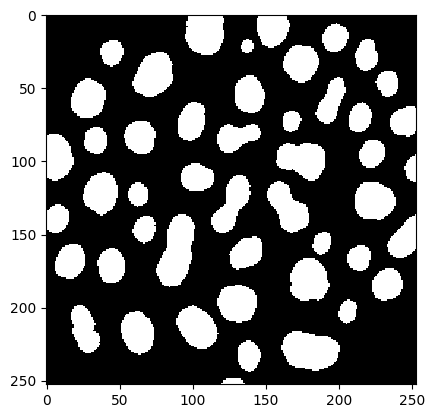

In [51]:
cle.imshow(result)